# Preparations

In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px

# Stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# Autocorr test
from statsmodels.stats.diagnostic import acorr_ljungbox

# Autocorrelation analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARMA models
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL, MSTL

In [2]:
!pip install pmdarima

# auto ARIMA
import pmdarima as pm
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00


In [3]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [4]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

# Data

We'll be analyzing closing stocks prices. Get data from [here](https://www.nasdaq.com/market-activity/stocks/amzn/historical?page=1&rows_per_page=10&timeline=m1).

Let's consider Amazon stocks- last month

In [5]:
amazon_data = pd.read_csv('amazon_1m_data.csv', parse_dates=['Date'])

In [6]:
amazon_data.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-12-16,$232.93,37552100,$230.23,$233.00,$228.01
1,2024-12-13,$227.46,28768080,$228.40,$230.20,$225.8608
2,2024-12-12,$228.97,28204080,$229.83,$231.09,$227.63
3,2024-12-11,$230.26,35385790,$226.41,$231.20,$226.26
4,2024-12-10,$225.04,31199860,$226.09,$229.06,$224.2002


Preprocessing data for comfortable work

The "high" column will be use as continuous regressor later

In [7]:
amazon_data.rename(columns={'Date':'ds', 'Close/Last':'y', 'High':'x'}, inplace=True) #, 'High':'x'

In [8]:
amazon_data['y'] = amazon_data['y'].apply(lambda x: x[1:]).astype(float)

In [9]:
amazon_data['x'] = amazon_data['x'].apply(lambda x: x[1:]).astype(float)

In [10]:
amazon_data = amazon_data[['ds','y', 'x']].sort_values(by='ds').set_index('ds')

In [11]:
amazon_data

,y,x
ds,,
2024-11-18,201.70,204.6700
2024-11-19,204.61,205.3000
2024-11-20,202.88,203.1300
2024-11-21,198.38,203.4900
2024-11-22,197.12,199.2599
2024-11-25,201.45,201.9499
2024-11-26,207.86,208.0000
2024-11-27,205.74,207.6400
2024-11-29,207.89,208.2000


Let's plot our data.

In [12]:
fig = px.line(amazon_data, x=amazon_data.index, y=amazon_data['y'],
              title="Tesla closing prices (daily)")

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

# Stationarity

Let's analyze the stationarity of time series

### ADF test

In [13]:
adf_test(amazon_data['y'])

Results of Dickey-Fuller Test:
Test Statistic                 -0.025934
p-value                         0.956334
#Lags Used                      0.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64


The defaults significance level is 5%.

<font color='red'>p-value > significance level </font>: : Don't reject the null hypothesis H(0), the **time series is stationary**.

#Analyze autocorrelation

Analyze autocorrelation of the time series with Ljung-Box test and ACF, PACF.

### Ljung-Box

In [14]:
acorr_ljungbox(amazon_data['y'], return_df=True)

,lb_stat,lb_pvalue
1,17.187559,3.386469e-05
2,31.239514,1.645984e-07
3,41.861732,4.292547e-09
4,47.809277,1.034255e-09


The defaults significance level is 5%.

<font color='red'>p-value <= significance level</font>: Reject the null hypothesis H(0), **the time series is autocorrelated**.

### ACF and PACF

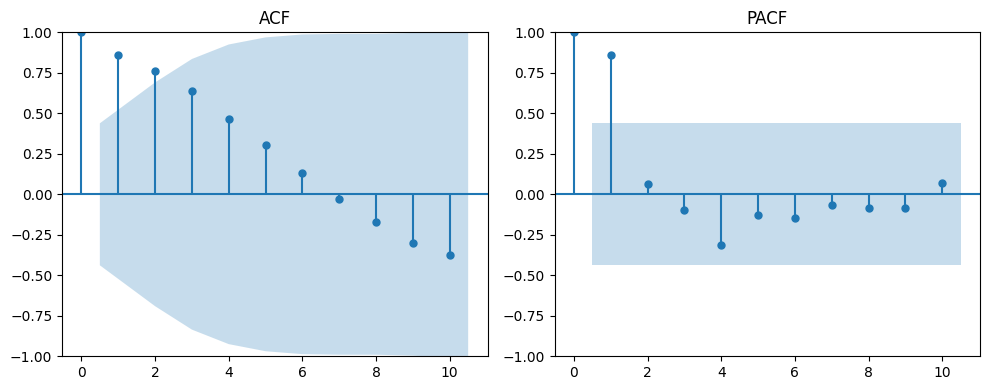

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(amazon_data['y'], ax=ax[0], lags=10)
ax[0].set_title('ACF')

# PACF
plot_pacf(amazon_data['y'], ax=ax[1], lags=10)
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

- ACF has 2 lag which is significant
- PACF has 1 lag which is significant

# Decomposition

Let's try to learn which part includes our time series and make our residuals not autocorrelated. Use MSTl because we can find more than 1 seasonalities (take 1 week and 2 weeks)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stl/mstl.py:218: UserWarning:

A period(s) is larger than half the length of time series. Removing these period(s).



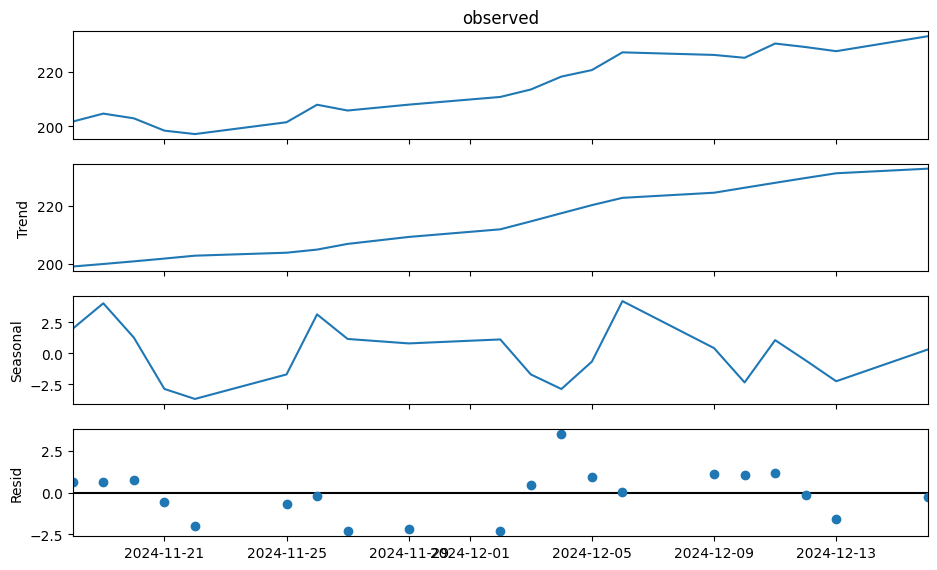

<Axes: xlabel='ds'>

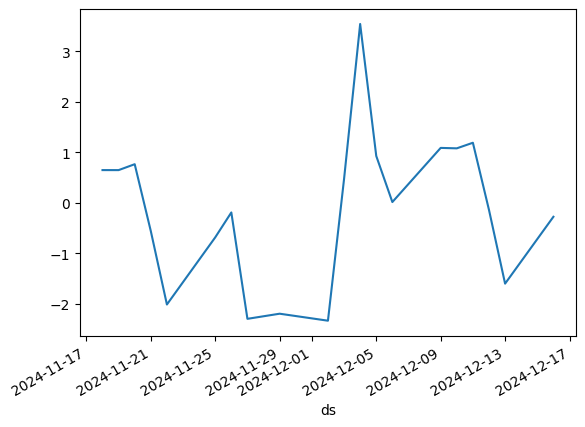

In [16]:
mstl = MSTL(amazon_data['y'], periods = (7, 14, 20))
res = mstl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()


res.resid.plot()

In [17]:
adf_test(res.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -2.588721
p-value                         0.095351
#Lags Used                      5.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


The defaults significance level is 5%.

<font color='red'>p-value > significance level </font>: : Don't reject the null hypothesis H(0), the **time series is NOT stationary**.

In [18]:
acorr_ljungbox(res.resid, return_df=True)

,lb_stat,lb_pvalue
1,5.508600,0.018923
2,5.561666,0.061987
3,5.809434,0.121259
4,5.859427,0.209895


The defaults significance level is 5%.

<font color='green'>p-value > significance level</font>: Don't eject the null hypothesis H(0), **the time series is NOT autocorrelated from 2 lags to the end**. We could find right patterns of this time series: seasonality and trend.

# Make time series stationary

For financial data more efficient use PCT_Change method to reduction our time series to stationarity version.  We use percent change because better use it for financial data

In [19]:
amazon_data['pct_change'] = amazon_data['y'].pct_change()*100
amazon_data.head( )

,y,x,pct_change
ds,,,
2024-11-18,201.70,204.6700,NaN
2024-11-19,204.61,205.3000,1.442737
2024-11-20,202.88,203.1300,-0.845511
2024-11-21,198.38,203.4900,-2.218060
2024-11-22,197.12,199.2599,-0.635145


Let's see if percent change made the time series stationary.

In [20]:
fig = px.line(amazon_data, x=amazon_data.index, y=amazon_data['pct_change'],
              title="Teslat closing prices (daily) - pct_change")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

The graph doesn't look quite clear let's check by tests

In [21]:
adf_test(amazon_data['pct_change'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -3.763375
p-value                         0.003305
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


<font color='green'>**p-value <= significance level**</font> => we reject H(0) and **the time series is stationary**.

In [22]:
kpss_test(amazon_data['pct_change'].dropna())

Results of KPSS Test:
Test Statistic           0.120798
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<ipython-input-4-71884a3c5bdd>:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




The defaults significance level is 5%.

<font color='green'>**p-value > significance level</font>: Don't reject the null hypothesis H(0), **the time series is stationary**.

So, we have brilliant time series which we can work with

# ARMA in sample predition

As we can remember our time series is stationarity and autocorrelated. So we can use ARMA model to make a predictoin

We need to choose right order for prediction. Let's look at ACF, PACF again and on AIC

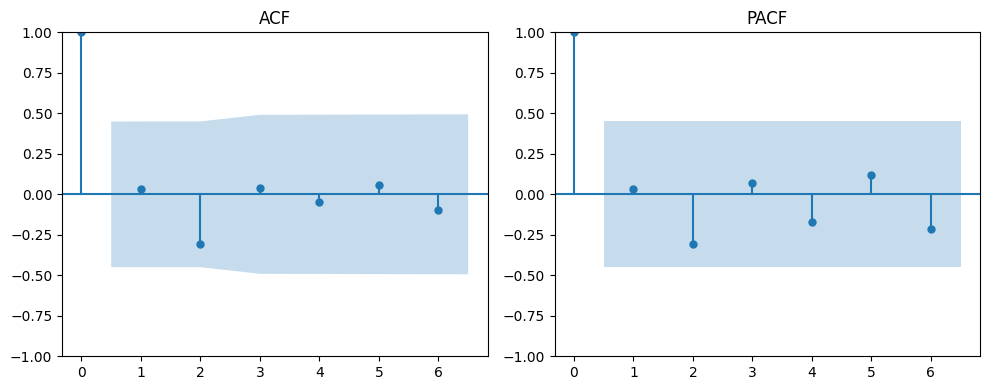

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(amazon_data['pct_change'].dropna(), ax=ax[0], lags=6)
ax[0].set_title('ACF')

# PACF
plot_pacf(amazon_data['pct_change'].dropna(), ax=ax[1], lags=6)
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

Order (0, 0, 0) prefer by looking on the ACF, PACF

AIC

In [24]:
best_params = []
for p in np.arange(0,7):
  for q in np.arange(0,7):
    model = ARIMA(amazon_data['pct_change'], order=(p, 0, q)).fit();
    best_params.append({'p':p, 'q': q, 'AIC': model.aic, 'BIC': model.bic});

pd.DataFrame(best_params).sort_values(by="AIC")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been prov

,p,q,AIC,BIC
2,0,2,72.991290,76.974219
0,0,0,74.053062,76.044527
9,1,2,74.498339,79.477000
8,1,1,74.602809,78.585738
3,0,3,74.644904,79.623565
15,2,1,75.480253,80.458915
4,0,4,75.775535,81.749929
14,2,0,75.877199,79.860128
1,0,1,75.991386,78.978582
7,1,0,76.032077,79.019274


As we can see the order (0, 0, 0) will give as more confident result with the smallest BIC like we choose orders in ACF, PACF

# ARMA in sample predition

In [25]:
model = ARIMA(amazon_data['pct_change'], order=(0, 0, 0))

#Fit model
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             pct_change   No. Observations:                   20
Model:                          ARIMA   Log Likelihood                 -35.027
Date:                Sat, 21 Dec 2024   AIC                             74.053
Time:                        11:17:03   BIC                             76.045
Sample:                             0   HQIC                            74.442
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7722      0.355      2.175      0.030       0.076       1.468
sigma2         2.3376      1.191      1.963      0.050       0.003       4.672
Ljung-Box (L1) (Q):                   0.02   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



As we can see only constant(mean) in our model in significant

Now, let's use ARMA for in-sample prediction

In [26]:
forecast = model.predict()

In [27]:
amazon_data['predict_pct'] = forecast

Let's look at the prediction on the plot

In [28]:
fig = px.line(title="Amazon closing prices (daily)_pct")
fig.add_scatter(x=amazon_data['pct_change'].index, y=amazon_data['pct_change'], mode='lines', name='y_pct', line=dict(color='blue'))

fig.add_scatter(x=amazon_data['predict_pct'].index, y=amazon_data['predict_pct'], mode='lines', name='predict_pct', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's return our data to initial:

In [29]:
y_0 = amazon_data['y'].iloc[0]
amazon_data['predict'] = amazon_data['y'].shift(1) * (1 + amazon_data['predict_pct'] / 100)

Let's look at the prediction on the plot

In [30]:
fig = px.line(title="Amazon closing prices (daily)")
fig.add_scatter(x=amazon_data['y'].index, y=amazon_data['y'], mode='lines', name='y', line=dict(color='blue'))

fig.add_scatter(x=amazon_data['predict'].index, y=amazon_data['predict'], mode='lines', name='predict', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [31]:
residuals = amazon_data['y'] - amazon_data['predict']

In [32]:
residuals.mean()

-0.0043959185732121925

Use MAE for measure our prediction for models in this work cause result is absolute, easier to interpret because the errors are in the original units.

In [33]:
mae_in_sample_ARMA = np.mean(np.abs(amazon_data['y'] - amazon_data['predict']))
print(mae_in_sample_ARMA)

2.9143428265585776


Note that the predicted y's are all the same. This is due to the fact that ARIMA can only predict the mean, and everything else is considered randomness. That's reason why we have reaaly big(bad) metric

So we don't need anymore columns predict_pct, predict. We can delete its

In [34]:
amazon_data.drop('predict_pct', axis=1, inplace=True)
amazon_data.drop('predict', axis=1, inplace=True)

# ARMA out-of-sample predition

We need minimal amout points equals 10 for predicting out-of-sample

In [35]:
train_size = int(len(amazon_data) * 0.50)
train, test = amazon_data['pct_change'][:train_size], amazon_data['pct_change'][train_size:]

In [36]:
forecast_size = len(amazon_data) - train_size

forecast_size

10

Let's draw plot of train and test data

In [37]:
fig = px.line(title="Amazon closing prices (daily) - pct")
fig.add_scatter(x=train.index, y=train, mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's make prediction by using ARMA model and order (0, 0, 0) which we found earlier as the best choice for AIC and BIC

In [38]:
model = ARIMA(train, order=(0, 0, 0))

#Fit model
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             pct_change   No. Observations:                   10
Model:                          ARIMA   Log Likelihood                 -17.329
Date:                Sat, 21 Dec 2024   AIC                             38.659
Time:                        11:17:04   BIC                             39.264
Sample:                             0   HQIC                            37.995
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5005      0.554      0.904      0.366      -0.585       1.586
sigma2         2.7542      1.994      1.381      0.167      -1.153       6.662
Ljung-Box (L1) (Q):                   0.29   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [39]:
y_hat = model.get_forecast(steps=forecast_size)
y_hat = y_hat.predicted_mean
y_hat = pd.DataFrame(y_hat)
y_hat['ds'] = test.index # redefine index for forecasts
y_hat = y_hat.set_index('ds')
y_hat

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



,predicted_mean
ds,
2024-12-03,0.500457
2024-12-04,0.500457
2024-12-05,0.500457
2024-12-06,0.500457
2024-12-09,0.500457
2024-12-10,0.500457
2024-12-11,0.500457
2024-12-12,0.500457
2024-12-13,0.500457


Let's plot our prediction

In [40]:
fig = px.line(title="Amazon closing prices (daily) - pct")
fig.add_scatter(x=train.index, y=train.to_frame()['pct_change'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test.to_frame()['pct_change'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=y_hat.index, y=y_hat['predicted_mean'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Finally, let's reverse our time series and the forecast to the original scales.

In [41]:
amazon_data['forecast_pct'] = y_hat['predicted_mean']

In [42]:
y_0 = amazon_data['y'].iloc[0]
amazon_data['forecast'] = amazon_data['y'].shift(1) * (1 + amazon_data['forecast_pct']  / 100)

Let's look at the plot

In [43]:
fig = px.line(title="Amazon closing prices (daily) ")
fig.add_scatter(x=amazon_data[:train_size].index, y=amazon_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=amazon_data[train_size:].index, y=amazon_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=amazon_data.index, y=amazon_data['forecast'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [44]:
mae_out_sample_ARMA = np.mean(np.abs(amazon_data['y'] - amazon_data['forecast']))
print(mae_out_sample_ARMA)

2.978310730734782


So we don't need anymore columns forecast_pct, forecast. We can delete its

In [45]:
amazon_data.drop('forecast_pct', axis=1, inplace=True)
amazon_data.drop('forecast', axis=1, inplace=True)

# ARIMA in-sample prediction

We need to find right order for p, d, q

Firstly, let's try to find d by differencing initial until it becomes stationary

In [46]:
amazon_data['diff'] = amazon_data['y'].diff()

Let's see if percent change made the time series stationary.

In [47]:
fig = px.line(amazon_data, x=amazon_data.index, y=amazon_data['diff'],
              title="Amazon closing prices (daily) - diff")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Plot looks stationary

Let's check it by using ADF, KPSS tests

In [48]:
adf_test(amazon_data['diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -3.820111
p-value                         0.002708
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


<font color='green'>**p-value <= significance level**</font> => we reject H(0) and **the time series is stationary**.

In [49]:
kpss_test(amazon_data['diff'].dropna())

Results of KPSS Test:
Test Statistic           0.128427
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<ipython-input-4-71884a3c5bdd>:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




The defaults significance level is 5%.

<font color='green'>p-value <= significance level </font>: Don't reject the null hypothesis H(0), **the time series is stationary**.

So, great, we only need to differentiate once to obtain the stationary series

Now, we need to find right order for the p, q. Let's look at the ACF, PACF and AIC, BIC

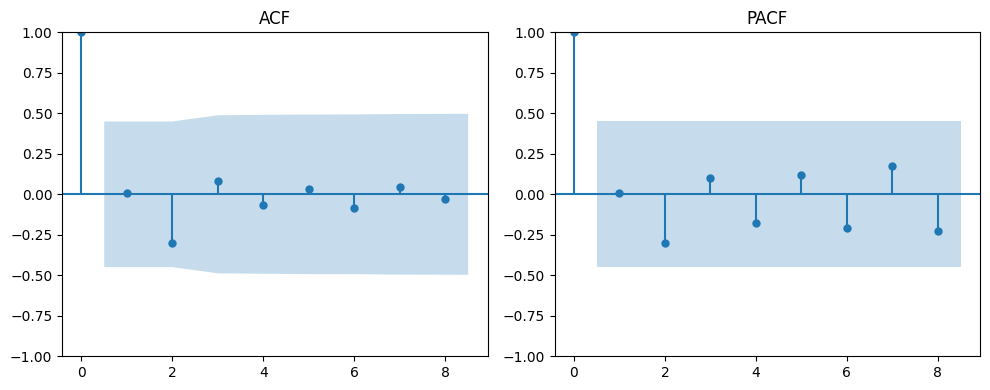

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(amazon_data['diff'].dropna(), ax=ax[0], lags=8)
ax[0].set_title('ACF')

# PACF
plot_pacf(amazon_data['diff'].dropna(), ax=ax[1], lags=8)
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

ACF, PACF plot tells us that we should choose p,q = (0, 0) cause we don't have significant lags

In [51]:
amazon_diff = amazon_data['diff'].dropna()

In [52]:
best_params = []
for p in np.arange(0,7):
  for q in np.arange(0,7):
    model = ARIMA(amazon_diff, order=(p, 0, q)).fit()
    best_params.append({'p':p, 'q': q, 'AIC': model.aic, 'BIC': model.bic})

pd.DataFrame(best_params).sort_values(by="AIC").head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been prov

,p,q,AIC,BIC
2,0,2,101.870287,105.648043
0,0,0,102.586844,104.475722
8,1,1,103.247569,107.025325
9,1,2,103.306410,108.028605
3,0,3,103.449274,108.171469


As we can see the order (0, 1, 0) will give as more confident result with the smallest BIC like we choose orders in ACF, PACF

So we're ready to predict in-sample ARIMA model

In [53]:
model = ARIMA(amazon_diff, order=(0,0,0))

#Fit model
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                   19
Model:                          ARIMA   Log Likelihood                 -49.293
Date:                Sat, 21 Dec 2024   AIC                            102.587
Time:                        11:17:28   BIC                            104.476
Sample:                             0   HQIC                           102.907
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6437      0.748      2.197      0.028       0.177       3.110
sigma2        10.4952      5.557      1.889      0.059      -0.396      21.387
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Now, let's use ARIMA for in-sample prediction

In [54]:
forecast = model.predict()

In [55]:
amazon_data['predict_diff'] = forecast

Let's look at the prediction on the plot

In [56]:
fig = px.line(title="Amazon closing prices (daily)_diff")
fig.add_scatter(x=amazon_data['diff'].index, y=amazon_data['diff'], mode='lines', name='y_diff', line=dict(color='blue'))

fig.add_scatter(x=amazon_data['predict_diff'].index, y=amazon_data['predict_diff'], mode='lines', name='predict_diff', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's return our data to initial scale:

In [57]:
y_0 = amazon_data['y'].iloc[0]
amazon_data['predict'] = np.cumsum(amazon_data['predict_diff'])+y_0

Let's look at the prediction on the plot

In [58]:
fig = px.line(title="Amazon closing prices (daily)_diff")
fig.add_scatter(x=amazon_data['y'].index, y=amazon_data['y'], mode='lines', name='y', line=dict(color='blue'))

fig.add_scatter(x=amazon_data['predict'].index, y=amazon_data['predict'], mode='lines', name='predict', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [59]:
residuals = amazon_data['y'] - amazon_data['predict']

In [60]:
residuals.mean()

-3.054159373975288

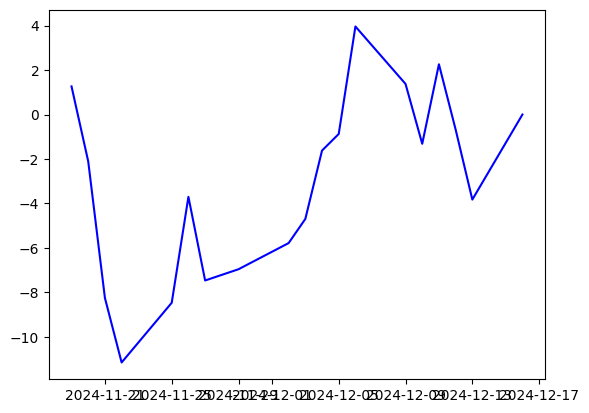

In [61]:
plt.plot(residuals, color='blue')

In [62]:
amazon_data['predict'] = amazon_data['predict'] + residuals.mean()

In [63]:
fig = px.line(title="Amazon closing prices (daily)_diff")
fig.add_scatter(x=amazon_data['y'].index, y=amazon_data['y'], mode='lines', name='y', line=dict(color='blue'))

fig.add_scatter(x=amazon_data['predict'].index, y=amazon_data['predict'], mode='lines', name='predict', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [64]:
residuals = amazon_data['y'] - amazon_data['predict']

In [65]:
residuals.mean()

7.47939721852737e-15

In [66]:
mae_in_sample_ARIMA = np.mean(np.abs(amazon_data['y'] - amazon_data['predict']))
print(mae_in_sample_ARIMA)

3.454747611019051


So we don't need anymore columns predict_diff, predict. We can delete its

In [67]:
amazon_data.drop('predict_diff', axis=1, inplace=True)
amazon_data.drop('predict', axis=1, inplace=True)

# ARIMA out-of-sample prediction

In [68]:
train_size = int(len(amazon_data) * 0.50)
train, test = amazon_data['y'][:train_size], amazon_data['y'][train_size:]

In [69]:
forecast_size = len(amazon_data) - train_size

forecast_size

10

In [70]:
fig = px.line(title="Amazon closing prices (daily)")
fig.add_scatter(x=train.index, y=train, mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test, mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's make prediction by using ARIMA model and order  (0, 1, 0) which we found earlier as the best choice for AIC and BIC

In [71]:
model = ARIMA(train, order=(0, 1, 0))

#Fit model
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -24.043
Date:                Sat, 21 Dec 2024   AIC                             50.087
Time:                        11:17:28   BIC                             50.284
Sample:                             0   HQIC                            49.661
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        12.2449      8.355      1.466      0.143      -4.130      28.619
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.62   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [72]:
y_hat = model.get_forecast(steps=forecast_size)
y_hat = y_hat.predicted_mean
y_hat = pd.DataFrame(y_hat)
y_hat['ds'] = test.index # redefine index for forecasts
y_hat = y_hat.set_index('ds')
y_hat

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



,predicted_mean
ds,
2024-12-03,210.71
2024-12-04,210.71
2024-12-05,210.71
2024-12-06,210.71
2024-12-09,210.71
2024-12-10,210.71
2024-12-11,210.71
2024-12-12,210.71
2024-12-13,210.71


In [73]:
amazon_data['predict'] = y_hat['predicted_mean']

In [74]:
amazon_data

,y,x,pct_change,diff,predict
ds,,,,,
2024-11-18,201.70,204.6700,NaN,NaN,NaN
2024-11-19,204.61,205.3000,1.442737,2.91,NaN
2024-11-20,202.88,203.1300,-0.845511,-1.73,NaN
2024-11-21,198.38,203.4900,-2.218060,-4.50,NaN
2024-11-22,197.12,199.2599,-0.635145,-1.26,NaN
2024-11-25,201.45,201.9499,2.196631,4.33,NaN
2024-11-26,207.86,208.0000,3.181931,6.41,NaN
2024-11-27,205.74,207.6400,-1.019917,-2.12,NaN
2024-11-29,207.89,208.2000,1.045008,2.15,NaN


Finally, let's reverse our time series and the forecast to the original scales.

In [75]:
fig = px.line(title="Amazon closing prices (daily)")
fig.add_scatter(x=amazon_data[:train_size].index, y=amazon_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=amazon_data[train_size:].index, y=amazon_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=amazon_data.index, y=amazon_data['predict'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [76]:
mae_out_of_sample_ARIMA = np.mean(np.abs(amazon_data['y'] - amazon_data['predict']))
print(mae_out_of_sample_ARIMA)

14.282999999999992


Delete some columns in the table. They don't need us anymore

In [77]:
amazon_data.drop(['predict'], axis=1, inplace=True)

# ADD Regressors

Let's add regressors:

**DUMMY REGRESSORS:**
1. Monday - 1 and other days 0. Cause monday is the day than starts trades on the week

2. Friday - 1 and other days 0. Cause friday is the day than ends trades on the week

**CONTINUOUS REGRESSORS:**
1. We will use "High" from initial table

### Dummy regressors

In [78]:
date_range = pd.date_range(start=amazon_data.index.min(), end=amazon_data.index.max()) #start=amazon_data.index.dropna().min()

# Create the DataFrame
regressors = pd.DataFrame(date_range, columns=["ds"])

In [79]:
regressors = regressors[~regressors['ds'].dt.weekday.isin([5, 6])]

In [80]:
regressors['mondays'] = regressors['ds'].dt.weekday.isin([0])*1
regressors['fridays'] = regressors['ds'].dt.weekday.isin([4])*1

regressors.set_index('ds', inplace=True)

regressors = regressors.join(amazon_data)[['mondays', 'fridays']]
regressors = pd.DataFrame(regressors)

regressors

,mondays,fridays
ds,,
2024-11-18,1,0
2024-11-19,0,0
2024-11-20,0,0
2024-11-21,0,0
2024-11-22,0,1
2024-11-25,1,0
2024-11-26,0,0
2024-11-27,0,0
2024-11-28,0,0


Let's plot dummy regressors

In [81]:
fig = px.line(title="Dummy regressor")
fig.add_scatter(x=regressors['mondays'].index, y=regressors['mondays'], mode='lines', name='mondays', line=dict(color='blue'))
fig.add_scatter(x=regressors['fridays'].index, y=regressors['fridays'], mode='lines', name='fridays', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=400)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

### Continuous regressors

In [82]:
# Create the DataFrame
regressors = regressors.join(amazon_data['x'], how='outer').fillna(method='ffill').loc[regressors.index.min():regressors.index.max()][['mondays', 'fridays', 'x']]


regressors

<ipython-input-82-dc2163c7a8b3>:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,mondays,fridays,x
ds,,,
2024-11-18,1,0,204.6700
2024-11-19,0,0,205.3000
2024-11-20,0,0,203.1300
2024-11-21,0,0,203.4900
2024-11-22,0,1,199.2599
2024-11-25,1,0,201.9499
2024-11-26,0,0,208.0000
2024-11-27,0,0,207.6400
2024-11-28,0,0,207.6400


In [83]:
regressors = regressors[regressors.index != '2024-11-28'] #our initial data don't have this data

# ARIMAX in-sample prediciton

Use the order=(0, 1, 0) which we found out earlier

In [84]:
model = ARIMA(amazon_data['y'], exog=regressors[['mondays', 'fridays', 'x']], order=(0, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -40.997
Date:                Sat, 21 Dec 2024   AIC                             89.995
Time:                        11:17:29   BIC                             93.773
Sample:                             0   HQIC                            90.634
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mondays       -0.3944      1.277     -0.309      0.757      -2.897       2.108
fridays        0.6873      1.543      0.445      0.656      -2.337       3.711
x              1.0098      0.330      3.064      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Only sigma2 is statistically significant

In [85]:
forecast = model_fit.predict()

In [86]:
amazon_data['pred'] = forecast

Let's compare plots

In [87]:
fig = px.line(title="Amazon closing prices (daily)")
fig.add_scatter(x=amazon_data.index, y=amazon_data['y'], mode='lines', name='y', line=dict(color='blue'))
fig.add_scatter(x=amazon_data.index, y=amazon_data['pred'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Check residuals after prediction

In [88]:
residuals = amazon_data['y'] - amazon_data['pred']

In [89]:
residuals.mean()

-0.09817495274834727

Good, the mean of residuals aroud 0

In [90]:
mae_in_sample_ARIMA_x = np.mean(np.abs(amazon_data['y'] - amazon_data['pred']))
print(mae_in_sample_ARIMA_x)

1.828051446923483


So we don't need anymore some columns. We can delete its

In [91]:
amazon_data.drop('pred', axis=1, inplace=True)

# ARIMAX out-of-sample prediciton

In [92]:
fig = px.line(title="Amazon closing prices (daily) ")
fig.add_scatter(x=amazon_data[:train_size].index, y=amazon_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=amazon_data[train_size:].index, y=amazon_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [93]:
model = ARIMA(train, exog=regressors[:train_size][['mondays', 'fridays','x']], order=(0, 1, 0)) # no need to add I, since the original y was already differenced.
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -19.910
Date:                Sat, 21 Dec 2024   AIC                             47.820
Time:                        11:17:30   BIC                             48.609
Sample:                             0   HQIC                            46.117
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mondays       -0.2476      2.150     -0.115      0.908      -4.462       3.966
fridays        0.9714      5.461      0.178      0.859      -9.733      11.675
x              0.9543      1.355      0.704      0.4

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [94]:
forecast = model_fit.predict(n_periods=forecast_size, exog = regressors[['mondays', 'fridays','x']][train_size:]) #start=test.index.min(), end=test.index.max()

In [95]:
forecast = pd.DataFrame(forecast)
forecast['ds'] = test.index
forecast.set_index('ds', inplace=True)
forecast.columns = ['y_hat']
display(forecast)

,y_hat
ds,
2024-12-03,195.076251
2024-12-04,202.548861
2024-12-05,202.539092
2024-12-06,203.223561
2024-12-09,195.314491
2024-12-10,198.468107
2024-12-11,207.471456
2024-12-12,207.516439
2024-12-13,207.245854


In [96]:
amazon_data['pred'] = forecast

In [97]:
fig = px.line(title="Amazon closing prices (daily) ")
fig.add_scatter(x=amazon_data[:train_size].index, y=amazon_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=amazon_data[train_size:].index, y=amazon_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=amazon_data.index, y=amazon_data['pred'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Look at the residuals

In [98]:
residuals = amazon_data['y'] - amazon_data['pred']

In [99]:
residuals.mean()

21.928367666714827

Let's try to add this to prediction

In [100]:
amazon_data['pred'] = amazon_data['pred'] + 21.928367666714827

In [101]:
residuals = amazon_data['y'] - amazon_data['pred']

In [102]:
residuals.mean()

5.684341886080802e-15

In [103]:
fig = px.line(title="Amazon closing prices (daily) ")
fig.add_scatter(x=amazon_data[:train_size].index, y=amazon_data['y'][:train_size], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=amazon_data[train_size:].index, y=amazon_data['y'][train_size:], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=amazon_data.index, y=amazon_data['pred'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Look not bad as was

In [104]:
mae_out_of_sample_ARIMA_x = np.mean(np.abs(amazon_data['y'] - amazon_data['pred']))
print(mae_out_of_sample_ARIMA_x)

3.2457829303338257


# Comparing metrics

In [105]:
print("ARMA (pct) in-sample: ", mae_in_sample_ARMA)
print("ARMA (pct) out-of-sample: ", mae_out_sample_ARMA)
print("ARIMA in-sample: ", mae_in_sample_ARIMA)
print("ARIMA out-of-sample: ", mae_out_of_sample_ARIMA)
print("ARIMAX in-sample: ", mae_in_sample_ARIMA_x)
print("ARIMAX out-of-sample: ", mae_out_of_sample_ARIMA_x)

ARMA (pct) in-sample:  2.9143428265585776
ARMA (pct) out-of-sample:  2.978310730734782
ARIMA in-sample:  3.454747611019051
ARIMA out-of-sample:  14.282999999999992
ARIMAX in-sample:  1.828051446923483
ARIMAX out-of-sample:  3.2457829303338257


The best result came from ARIMAX

The worst result came from ARIMA